In [82]:
import platform

global systemDivide
if platform.platform().split('-')[0] == 'macOS':
    systemDivide = '/'
else:
    systemDivide = '\\'

import sys
import threading

threading.stack_size(2**27)
sys.setrecursionlimit(10 ** 5)

In [83]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

pairName = 'CHFJPY.csv'

inpData = pd.read_csv(f"testData{systemDivide}{pairName}", index_col=1)
# Какие колонки нужны для работы
columns = ['open', 'high', 'low', 'close']
inpData = inpData[columns]
inpData.index = pd.to_datetime(inpData.index)


initParameters = {
    # Оптимизировать
    'yThreshold': 300,
    # Оптимизировать
    'yBackThreshold': 0,
    # Оптимизировать
    'varianceRatioFilter': 1.0,
    # Оптимизировать
    'restAfterLoss': 910,
    # Оптимизировать
    'varianceRatioCarreteParameter': 10,
    # Оптимизировать
    'stopLossM': 700,
    # Оптимизировать
    'scanHalfTime': 1500
    }

def create_grid(params: initParameters):
    """
    Создает удобную сетку для дальнейших расчетов
    :param params: начальные init параметры
    :return: словарь из параметров использующийся везде
    """
    capital = 20_000
    slippage = 2
    retParams = {
        # Капитал
        'capital': capital,
        'slippage': slippage,
        # Можно использовать для стоп лоссов и тейков с учетом слипэджа
        'slippagePerCapital': slippage / capital,
        # То какой размах мы будем брать для построения полос Боллинджера. Это и есть X Threshold из файла Евгения
        'yThreshold': round(params['yThreshold'] / 100, 2),
        'yBackThreshold': round(params['yBackThreshold'] / 100, 2),
        # Период за который мы строим малую скользяшку
        'rollingMean': None,
        # Период за который мы строим большую скользяшку
        'fatRollingMean': None,
        # Временной барьер, Максимальное время сколько мы можем держать позицию
        'timeBarrier': None,
        # Параметр для определения того что данные MeanReversion/TrendFollowing
        # Используется в VRratio тестах для открытия/удержания позиции
        'varianceRatioFilter': params['varianceRatioFilter'],
        # Сколько времени мы не торгуем после срабатывания стоп лосса
        'restAfterLoss': params['restAfterLoss'],
        # Сколько времени мы не торгуем после закрытия позиции о большую скользяшку
        'restAfterFatProfit' : 0,
        # Процент стоп лосса
        'stopLossStdMultiplier': params['stopLossM'],
        # Процент тэйк профита
        'takeProfitStdMultiplier': None,
        # Нужно чтобы пересчитывать VR границы в автоматическом режиме
        'varianceRatioCarreteParameter': params['varianceRatioCarreteParameter'],
        # Тот период за который мы будем считать Variance Ratio. Те ставя тут к примеру 1500, мы должны будем передавать в функцию
        # VR Ratio 1500 точек данных. Сейчас этот гипермараметр связан с гиперпараметров периода малой скользяшки
        'varianceLookBack': None,
        # Чему будет равен временной лаг Q; Q = varianceLookBack // PARAM + 1
        'varianceRatioCarrete': None,
        # Параметр по которому мы будем искать период полураспада
        'scanHalfTime': params['scanHalfTime'],

        'dynamicHalfTime': None,
        'dynamicOperation': None,
        "dynamicStopLoss": None,
        'dynamicSTD': None,
    }
    return retParams

# Проверим распределение доходностей на нормальность

3 sigma anomalies 1.275%


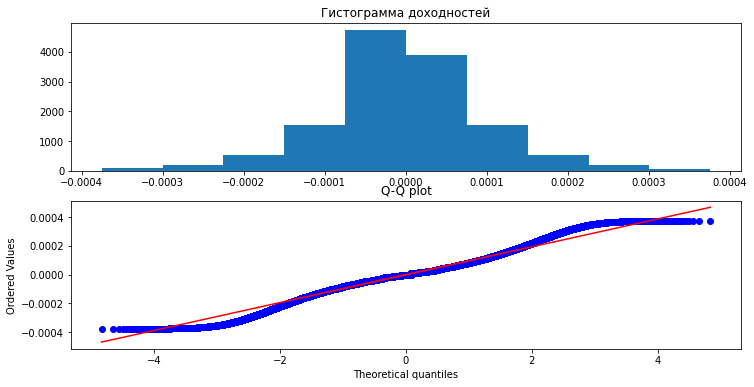

In [84]:
import matplotlib.pylab as plt
from scipy.stats import zscore, probplot
from sklearn import linear_model

plt.style.use(style='fast')
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.title('Гистограмма доходностей')
abs_Z_scores = np.abs(zscore(inpData.open.pct_change().iloc[1:]))
filtered = (abs_Z_scores < 3)
print(f'3 sigma anomalies {(1 - sum(filtered) / inpData.shape[0]):.3%}')
bars = plt.hist(inpData.open.pct_change().values[1:][filtered], density=True, )
ax = plt.subplot(2,1,2)

probplot(inpData.open.pct_change().values[1:][filtered], plot=ax)
plt.title(f'Q-Q plot')
plt.show()
del abs_Z_scores, filtered, bars

In [85]:
def get_half_time(openTuple: pd.Series) -> float:
    df_open = openTuple.to_frame()
    df_lag = df_open.shift(1)
    df_delta = df_open - df_lag
    linear_regression_model = linear_model.LinearRegression()
    df_delta = df_delta.values.reshape(len(df_delta), 1)
    df_lag = df_lag.values.reshape(len(df_lag), 1)
    linear_regression_model.fit(df_lag[1:], df_delta[1:])
    half_life = -np.log(2) / linear_regression_model.coef_.item()
    return half_life

def varianceRatio(df:pd.DataFrame, params: dict) -> bool:
    """
    Возвращает значение variacne ratio. Необходимо для понимания того, можно ли открывать сделку
    :param df
    :param params: список параметров из create_grid
    :return: Можно ли открывать сделку. Фактически является фильтром
    """
    logTuple = np.log(df.close)
    retTuple = logTuple.diff().iloc[1:]
    logTuple = logTuple.iloc[1:]

    buffer_size = len(retTuple)
    means = (1 / buffer_size) * np.sum(retTuple)
    # сдвиг во времени q
    m = params['varianceRatioCarrete'] * (buffer_size - params['varianceRatioCarrete'] + 1 ) * (1 - (params['varianceRatioCarrete'] / buffer_size))
    sigma_a = (1 / (buffer_size - 1)) * np.sum(np.square(np.subtract(retTuple, means)))
    subtract_returns = np.subtract(logTuple, np.roll(logTuple, params['varianceRatioCarrete']))[params['varianceRatioCarrete']:]
    _buff_ = np.sum(np.square(subtract_returns - params['varianceRatioCarrete'] * means))
    try:
        sigma_b = (1 / m) * _buff_
    except ZeroDivisionError:
        return False

    result = (sigma_b / sigma_a)
    if result < params['varianceRatioFilter']:
        return True
    else:
        return False

def open_position(locator, dataFrame, params):
    statement = False
    half_time = int(get_half_time(dataFrame.close.iloc[locator-params['scanHalfTime']:locator]))
    if (half_time > params['scanHalfTime']) or (half_time < 0):
        return {'operation': None, 'locator': locator+1}


    params['dynamicHalfTime'] =  half_time
    params["rollingMean"] = half_time
    params["timeBarrier"] = half_time
    params["varianceLookBack"] = half_time
    params["varianceRatioCarrete"] = int(half_time // params['varianceRatioCarreteParameter']) + 1
    # Считаем локальные барьеры открытия сделки
    bands_roll = dataFrame.close.iloc[locator-half_time:locator].rolling(half_time)
    bands_mean = bands_roll.mean().iloc[-1]
    bands_std = bands_roll.std().iloc[-1]
    params["dynamicSTD"] = bands_std
    low_band = bands_mean - bands_std * params['yThreshold']
    high_band = bands_mean + bands_std * params['yThreshold']
    # Добавляем дополнительную единицу, связанную с diff
    if dataFrame.close.iloc[locator] < low_band:
        if varianceRatio(dataFrame.iloc[locator - params['varianceLookBack'] - 1: locator], params=params):
            return {'operation': 'buy', 'locator': locator+1}
    elif dataFrame.close.iloc[locator] > high_band:
        if varianceRatio(dataFrame.iloc[locator - params['varianceLookBack'] - 1: locator], params=params):
            return {'operation': "sell", 'locator': locator+1}
    else:
        return {'operation': None, 'locator':locator+1}

    if not statement:
        return {'operation': None, 'locator':locator+1}

def close_position(locator, dataFrame, params, timeBarrier):
    statement = False

    bands_roll = dataFrame.close.iloc[locator-params['dynamicHalfTime']:locator].rolling(params['dynamicHalfTime'])
    bands_mean = bands_roll.mean().iloc[-1]
    bands_std = bands_roll.std().iloc[-1]
    low_band = bands_mean - bands_std * params['yBackThreshold']
    high_band = bands_mean + bands_std * params['yBackThreshold']
    if timeBarrier > params['timeBarrier']:
        return {'hold': 'time', 'locator': locator+1}

    elif params["dynamicOperation"] == 'buy':
        if dataFrame.close.iloc[locator] < params['dynamicStopLoss']:
            return {'hold': 'stopLoss', 'locator': locator+1}
        elif dataFrame.close.iloc[locator] > high_band:
            return {'hold': 'band', 'locator': locator+1}
        else:
            delta = dataFrame.close.iloc[locator] - dataFrame.close.iloc[locator - 1]
            if delta > 0:
                params['dynamicStopLoss'] += delta
                return {'hold': None, 'locator': locator+1}

    elif params["dynamicOperation"] == 'sell':
        if dataFrame.close.iloc[locator] > params['dynamicStopLoss']:
            return {'hold': 'stopLoss', 'locator': locator+1}
        elif dataFrame.close.iloc[locator] < low_band:
            return {'hold': 'band', 'locator': locator+1}
        else:
            delta = dataFrame.close.iloc[locator] - dataFrame.close.iloc[locator - 1]
            if delta < 0:
                params['dynamicStopLoss'] += delta
                return {'hold': None, 'locator': locator+1}

    if not statement:
        return {'hold': None, 'locator': locator+1}

In [ ]:
RESULTS = list()
parameters = create_grid(initParameters)

data = inpData.copy()

openDict = {'operation': None, 'locator': parameters["scanHalfTime"]}

simplifier = 6

barTqdm = tqdm(total=int(data.shape[0] // simplifier))
while openDict["locator"] < int(data.shape[0] // simplifier):
    while openDict["operation"] is None:
        openDict = open_position(locator=openDict["locator"] + 1, dataFrame=data, params=parameters)

    openPrice = data.close.iloc[openDict['locator']]
    openIndex = openDict['locator']


    parameters['dynamicOperation'] = openDict["operation"]
    if parameters['dynamicOperation'] == 'buy':
        parameters["dynamicStopLoss"] = openPrice - parameters["dynamicSTD"] * parameters["stopLossStdMultiplier"]
        # print(f'operation={parameters["dynamicOperation"]} open={openPrice}, SL={parameters["dynamicStopLoss"]}')
    if parameters['dynamicOperation'] == 'sell':
        parameters["dynamicStopLoss"] = openPrice + parameters["dynamicSTD"] * parameters["stopLossStdMultiplier"]

    closeDict = {'hold': None, 'locator': openDict['locator']}
    timeB = 1
    while closeDict["hold"] is None:
        timeB += 1
        closeDict = close_position(locator=closeDict["locator"]+1, dataFrame=data, params=parameters,
                                   timeBarrier=timeB)

    closePrice = data.close.iloc[closeDict["locator"]]
    closeIndex = closeDict["locator"]
    openDict = {'operation': None, 'locator': closeDict["locator"]}
    if closeDict["hold"] == 'stopLoss':
        openDict["locator"] += parameters["restAfterLoss"]

    barTqdm.update(closeIndex - barTqdm.last_print_n)
    RESULTS.append({'operation': parameters['dynamicOperation'],
                    'hold': closeDict['hold'],
                    'open': openPrice,
                    'close': closePrice,
                    'openIndex': openIndex,
                    'closeIndex': closeIndex})

  0%|          | 0/179815 [00:00<?, ?it/s]

In [ ]:
stat = pd.DataFrame(RESULTS)
def profit_calculation(line, params):
    if line.operation == 'sell':
        position = params['capital'] / line.open
        return position * (line.open - line.close) - params['slippage']
    if line.operation == 'buy':
        position = params['capital'] / line.open
        return position * (line.close - line.open) - params['slippage']
stat['profit'] = stat.apply(lambda x: profit_calculation(x, params=parameters), axis=1)
stat

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(stat.profit.cumsum())
plt.show()